# Using 🤗 datasets for image search
> Using the 🤗 datasets to make an image search engine for British Library Book Illustrations 

- toc: true 
- badges: false
- comments: true
- categories: [metadata, deployment,huggingface, ethics, huggingface-datasets, faiss]
- search_exclude: false

**tl;dr** it's really easy to use the huggingface datasets library to create an image search application super easily but it might not be suitable for sharing. 

> 🤗 Datasets is a library for easily accessing and sharing datasets, and evaluation metrics for Natural Language Processing (NLP), computer vision, and audio tasks. [source](https://huggingface.co/docs/datasets/)

When datasets was first launched it was more usually associated with text data and nlp. However, datasets has got support for images. In particular there is now a datasets `feature` type for images{% fn 15 %}. In this blog post I try and play around with this new datatype, in combination with some other nice features of the library to make an image search app. 


To start lets take a look at the image feature. We can use the wonderful [rich](https://rich.readthedocs.io/) libary to poke around python objects (functions, classes etc.)

{{ "If you aren't familiar with datasets. A feature represents the datatype for different data you can have inside a dataset. For example you my have int32, timestamps and strings. You can read more about how features work in the docs" | fndetail: 15 }}

In [ ]:
from rich import inspect
from datasets.features import features

In [ ]:
inspect(features.Image, help=True)

╭──────────────────── <class 'datasets.features.image.Image'> ─────────────────────╮
│ def Image(id: Union[str, NoneType] = None) -> None:                              │
│                                                                                  │
│ Image feature to read image data from an image file.                             │
│                                                                                  │
│ Input: The Image feature accepts as input:                                       │
│ - A :obj:`str`: Absolute path to the image file (i.e. random access is allowed). │
│ - A :obj:`dict` with the keys:                                                   │
│                                                                                  │
│     - path: String with relative path of the image file to the archive file.     │
│     - bytes: Bytes of the image file.                                            │
│                                                                                  │
│   This is useful for archived files with sequential access.                      │
│                                                                                  │
│ - An :obj:`np.ndarray`: NumPy array representing an image.                       │
│ - A :obj:`PIL.Image.Image`: PIL image object.                                    │
│                                                                                  │
│   dtype = 'dict'                                                                 │
│      id = None                                                                   │
│ pa_type = None                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────╯

We can see there a few different ways in which we can pass in our images. We'll come back to this in a little while. 

A really nice feature of the datasets library (beyond the functionality for processing data, memory mapping etc.) is that you get some nice things for free. One of these is the ability to add a faiss index. [faiss](https://github.com/facebookresearch/faiss) is a ["library for efficient similarity search and clustering of dense vectors"](https://github.com/facebookresearch/faiss). 

The datasets [docs](https://huggingface.co/docs) show and example of using faiss for text retrieval. What I'm curious about doing is using the faiss index to search for images. This can be super useful for a number of reasons but also comes with some potential issues.

## The dataset: "Digitised Books - Images identified as Embellishments. c. 1510 - c. 1900. JPG"

This is a dataset of images which have been pulled from a collection of digitised books from the British Library. These images come from books across a wide time period and from a broad range of domains. These images were extracted using information in the OCR output for each book. As a result it's known which book the images came from but not 
necessarily anything else about that image i.e. what it is of. 

Some attempts to help overcome this have included uploading the images to [flickr](https://www.flickr.com/photos/britishlibrary/albums). This allows people to tag the images or put them into various different categories. 

There have also been projects to tag the dataset [using machine learning](https://blogs.bl.uk/digital-scholarship/2016/11/sherlocknet-update-millions-of-tags-and-thousands-of-captions-added-to-the-bl-flickr-images.html). This work already makes it possible to search by tags but we might want a 'richer' ability to search. For this particular experiment I will work with a subset of the collections which contain "embellishments". This dataset is a bit smaller so will be better for experimenting with. We can get the data from the BL repository: [https://doi.org/10.21250/db17](https://doi.org/10.21250/db17)

In [ ]:
# hide_output
!aria2c -x8 -o dig19cbooks-embellishments.zip "https://bl.iro.bl.uk/downloads/ba1d1d12-b1bd-4a43-9696-7b29b56cdd20?locale=en"


01/12 20:18:42 [NOTICE] Downloading 1 item(s)

01/12 20:18:42 [NOTICE] Removed the defunct control file /Users/dvanstrien/Documents/daniel/blog/_notebooks/dig19cbooks-embellishments.zip.aria2 because the download file /Users/dvanstrien/Documents/daniel/blog/_notebooks/dig19cbooks-embellishments.zip doesn't exist.

01/12 20:18:42 [NOTICE] Allocating disk space. Use --file-allocation=none to disable it. See --file-allocation option in man page for more details.
 *** Download Progress Summary as of Wed Jan 12 20:19:43 2022 ***              58s](98%)]m
[#f38a5d 553MiB/43GiB(1%) CN:5 DL:36MiB ETA:19m55s]
FILE: /Users/dvanstrien/Documents/daniel/blog/_notebooks/dig19cbooks-embellishments.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Wed Jan 12 20:20:44 2022 ***              46s]
[#f38a5d 2.6GiB/43GiB(6%) CN:5 DL:37MiB ETA:18m38s]
FILE: /Users/dvanstrien/Documents/daniel/blog/_notebooks/dig19cbooks-embellishments.zip

In [ ]:
!unzip -q dig19cbooks-embellishments.zip

## Install required packages

There are a few packages we'll need for this work. To start with we'll need the datasets library. 

In [ ]:
# hide output
import sys
!{sys.executable} -m pip install datasets 

Now we have the data downloaded we'll try and load it into datasets. There are various ways of doing this. To start with we can grab all of the files we need. 

In [ ]:
from pathlib import Path

In [ ]:
files = list(Path('embellishments/').rglob("*.jpg"))

Since the file path encodes the year of publication for the book the image came from let's create a function to grab that.

In [ ]:
def get_parts(f:Path):
    _,year,fname =  f.parts
    return year, fname

## 📸 Loading the images 

The images are fairly large, since this is an experiment we'll resize them a little using the `thumbnail` method (this makes sure we keep the same aspect ratio for our images)

In [ ]:
from PIL import Image
import io

In [ ]:
def load_image(path):
    with open(path, 'rb') as f:
        im = Image.open(io.BytesIO(f.read()))
        im.thumbnail((224,224))
    return im 

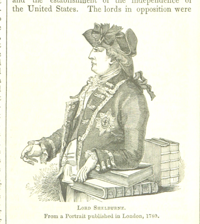

In [ ]:
im = load_image(files[0])
im

### Where is the image 🤔
You may have noticed that the `load_image` function doesn't load the filepath into pillow directly. Often we would do `Image.open(filepath.jpg)`. This is done deliberately. If we load it this way when we inspect the resulting image you'll see that the filepath attribute is empty.

In [ ]:
#collapse_output
inspect(im)

╭─────────────────────── <class 'PIL.JpegImagePlugin.JpegImageFile'> ───────────────────────╮
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x224 at 0x7FBBB392D040>     │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│                app = {'APP0': b'JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'}            │
│            applist = [('APP0', b'JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00')]          │
│               bits = 8                                                                    │
│    custom_mimetype = None                                                                 │
│      decoderconfig = (2, 0)                                                               │
│    decodermaxblock = 65536                                                                │
│      encoderconfig = (False, -1, -1, b'')                                                 │
│        encoderinfo = {}                                                                   │
│           filename = ''                                                                   │
│             format = 'JPEG'                                                               │
│ format_description = 'JPEG (ISO 10918)'                                                   │
│                 fp = None                                                                 │
│             height = 224                                                                  │
│         huffman_ac = {}                                                                   │
│         huffman_dc = {}                                                                   │
│            icclist = []                                                                   │
│                 im = <ImagingCore object at 0x7fbba120dc10>                               │
│               info = {                                                                    │
│                          'jfif': 257,                                                     │
│                          'jfif_version': (1, 1),                                          │
│                          'jfif_unit': 0,                                                  │
│                          'jfif_density': (1, 1)                                           │
│                      }                                                                    │
│              layer = [(1, 2, 2, 0), (2, 1, 1, 1), (3, 1, 1, 1)]                           │
│             layers = 3                                                                    │
│                map = None                                                                 │
│               mode = 'RGB'                                                                │
│            palette = None                                                                 │
│           pyaccess = None                                                                 │
│       quantization = {                                                                    │
│                          0: [                                                             │
│                              2,                                                           │
│                              2,                                                           │
│                              1,                                                           │
│                              2,                                                           │
│                              3,                                                           │
│                              6,                                                           │
│                              7,                   

You can also directly see this

In [ ]:
im.filename

''

Pillow usually loads images in a lazy way i.e. it only opens them when they are needed. The filepath is used to access the image. We can see the filename attribute is present if we open it from the filepath

In [ ]:
im_file = Image.open(files[0])
im_file.filename

'/Users/dvanstrien/Documents/daniel/blog/_notebooks/embellishments/1855/000811462_05_000205_1_The Pictorial History of England  being a history of the people  as well as a hi_1855.jpg'

The reason I don't want the filename attribute present here is because not only do I want to use datasets to process our images but also *store* the images. If we pass a Pillow object with the filename attribute datasets will also use this for loading the images. This is often what we'd want but we don't want this here for reasons we'll see shortly. 

### Preparing images for datasets

We can now load our images. What we'll do is is loop through all our images and then load the information for each image into a dictionary.

In [ ]:
from collections import defaultdict

In [ ]:
data = defaultdict(list)

In [ ]:
from tqdm import tqdm

In [ ]:
for file in tqdm(files):
    try:
        #load_image(file)
        year, fname = get_parts(file)
        data['fname'].append(fname)
        data['year'].append(year)
        data['path'].append(str(file))
    except:
        Image.UnidentifiedImageError
        pass
        

100%|████████████████████████████████████████████████████████████████████████████████████████████| 416944/416944 [00:05<00:00, 77169.45it/s]


We can now load the `from_dict` method to create a new dataset. 

In [ ]:
from datasets import Dataset

In [ ]:
dataset = Dataset.from_dict(data)

We can look at one example to see what this looks like. 

In [ ]:
dataset[0]

{'fname': '000811462_05_000205_1_The Pictorial History of England  being a history of the people  as well as a hi_1855.jpg',
 'year': '1855',
 'path': 'embellishments/1855/000811462_05_000205_1_The Pictorial History of England  being a history of the people  as well as a hi_1855.jpg'}

### Loading our images

At the moment our dataset has the filename and full path for each image. However, we want to have an actual image loaded into our dataset. We already have a `load_image` function. This gets us most of the way there but we might also want to add some ability to deal with image errors. The datasets library has gained increased uspport for handling `None` types- this includes support for `None` types for images see [pull request 3195](https://github.com/huggingface/datasets/pull/3195). 

We'll wrap our `load_image` function in a try block, catch a `Image.UnidentifiedImageError` error and return None if we can't load the image. 

In [ ]:
def try_load_image(filename):
    try:
        image = load_image(filename)
        if isinstance(image, Image.Image):
            return image
    except Image.UnidentifiedImageError:
        return None

In [ ]:
%%time
dataset = dataset.map(lambda example: {"img": try_load_image(example['path'])},writer_batch_size=50)

  0%|          | 0/416944 [00:00<?, ?ex/s]

CPU times: user 51min 42s, sys: 4min 31s, total: 56min 13s
Wall time: 1h 10min 31s


Let's see what this looks like

In [ ]:
dataset

Dataset({
    features: ['fname', 'year', 'path', 'img'],
    num_rows: 416944
})

We have an image column, let's check the type of all our features

In [ ]:
dataset.features

{'fname': Value(dtype='string', id=None),
 'year': Value(dtype='string', id=None),
 'path': Value(dtype='string', id=None),
 'img': Image(id=None)}

This is looking great already. Since we might have some `None` types for images let's get rid of these. 

In [ ]:
dataset = dataset.filter(lambda example: example['img'] is not None)

  0%|          | 0/417 [00:00<?, ?ba/s]

In [ ]:
dataset

Dataset({
    features: ['fname', 'year', 'path', 'img'],
    num_rows: 416935
})

You'll see we lost a few rows by doing this filtering. We should now just have images which are successfully loaded. 

If we access an example and index into the `img` column we'll see our image 😃

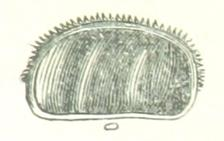

In [ ]:
dataset[10]['img']

## Push all the things to the hub! 

![Push all the things to the hub!](https://i.imgflip.com/613c0r.jpg)

One of the super awesome things about the huggingface ecosystem is the huggingface hub. We can use the hub to access models and datasets. Often this is used for sharing work with others but it can also be a useful tool for work in progress. The datasets library recently added a `push_to_hub` method that allows you to push a dataset to the hub with minimal fuss. This can be really helpful by allowing you to pass around a dataset with all the transformers etc. already done. 

When I started playing around with this feature I was also keen to see if it could be used as a way of 'bundling' everything together. This is where I noticed that if you push a dataset containing images which have been loaded in from filepaths by pillow the version on the hub won't have the images attached. If you always have the image files in the same place when you work with the dataset then this doesn't matter. If you want to have the images stored in the parquet file(s) associated with the dataset we need to load it without the filename attribute present (there might be another way of ensuring that datasets doesn't rely on the image file being on the file system -- if you of this I'd love to hear about it). 

Since we loaded our images this way when we download the dataset from the hub onto a different machine we have the images already there 🤗


For now we'll push the dataset to the hub and keep them private initially.

In [ ]:
dataset.push_to_hub('davanstrien/embellishments', private=True)

The repository already exists: the `private` keyword argument will be ignored.


Deleting unused files from dataset repository:   0%|          | 0/48 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/6 [00:00<?, ?it/s]

### Switching machines

At this point I've created a dataset and moved it to the huggingface hub. This means it is possible to pickup the work/dataset elsewhere. 

In this particular example, having access to a GPU is important. So the next parts of this notebook are run on Colab instead of locally on my laptop. 

We'll need to login since the dataset is currently private.  

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine

Once we've done this we can load our dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("davanstrien/embellishments", use_auth_token=True)

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Using custom data configuration davanstrien--embellishments-543da8e15e8f0242


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/423M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/423M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/davanstrien--embellishments-543da8e15e8f0242/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Creating embeddings 🕸

We now have a dataset with a bunch of images in it. To begin creating our image search app we need to create some embeddings for these images. There are various ways in which we can try and do this but one possible way is to use the clip models via the `sentence_transformers` library. The [clip model](https://openai.com/blog/clip/) from OpenAI learns a joint representation for both images and text which is very useful for what we want to do since we want to be able to input text and get back an image. We can download the model using the `SentenceTransformer` class. 

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


This model will encode either an image or some text returning an embedding. We can use the `map` method to encode all our images. 

In [ ]:
ds_with_embeddings = dataset.map(
    lambda example: {'embeddings':model.encode(example['img'],device='cuda')},
                                 batch_size=32)

  0%|          | 0/416935 [00:00<?, ?ex/s]

We can "save" our work by pushing back to the hub 

In [ ]:
ds_with_embeddings.push_to_hub('davanstrien/embellishments', private=True)

Pushing split train to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Deleting unused files from dataset repository:   0%|          | 0/6 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/7 [00:00<?, ?it/s]

If we were to move to a different machine we could grab our work again by loading it from the hub 😃

In [ ]:
from datasets import load_dataset

ds_with_embeddings = load_dataset("davanstrien/embellishments", use_auth_token=True)

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Using custom data configuration davanstrien--embellishments-c2c1f142f272db02


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/494M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/485M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/davanstrien--embellishments-c2c1f142f272db02/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

We now have a new column which contains the embeddings for our images. We could manually search through these and compare it to some input embedding but datasets has an `add_faiss_index` method. This uses the [faiss](https://github.com/facebookresearch/faiss) library to create an efficient index for searching embeddings. For more background on this library you can watch this youtube video

<iframe width="560" height="315" src="https://www.youtube.com/embed/sKyvsdEv6rk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
ds_with_embeddings['train'].add_faiss_index(column='embeddings')

  0%|          | 0/417 [00:00<?, ?it/s]

Dataset({
    features: ['fname', 'year', 'path', 'img', 'embeddings'],
    num_rows: 416935
})

## Image search
We now have everything we need to create a simple image search. We can use the same model we used to encode our images to encode some input text. This will act as the prompt we try and find close examples for. Let's start with 'a steam engine'. 

In [ ]:
prompt = model.encode("A steam engine")

We can see what this looks like

In [ ]:
#collapse_output
prompt

array([-4.68399227e-02, -1.25237599e-01,  1.25164926e-01,  1.23583399e-01,
        5.36684394e-02, -2.80560672e-01,  2.89631691e-02, -9.63450074e-01,
       -1.52872965e-01, -3.83016393e-02,  9.01967064e-02, -5.84575422e-02,
        1.04646191e-01,  2.44443744e-01,  1.38233244e-01, -3.97525132e-02,
        4.35137331e-01, -4.26820181e-02, -8.48560631e-02, -6.94137365e-02,
        6.25562131e-01,  3.68572891e-01,  3.34365219e-01, -3.37864846e-01,
       -2.53632635e-01, -3.01467925e-01, -1.56484097e-01,  2.94869483e-01,
       -1.89204350e-01, -1.13111593e-01, -1.46938376e-02,  2.97405511e-01,
       -2.92487741e-01,  3.56931627e-01,  1.44009173e-01,  7.53008351e-02,
       -1.02462962e-01,  2.26309776e-01, -3.77506733e-01,  4.75439876e-02,
       -8.52131844e-03,  7.40285963e-03, -1.36876494e-01,  1.12041593e-01,
        3.65501434e-01, -9.37360153e-02,  1.00782610e-01, -3.86462212e-01,
       -1.39045209e-01, -2.31989667e-01, -2.62126565e-01,  8.75059143e-02,
       -9.87479314e-02,  

We can use another method from the datasets library `get_nearest_examples` to get images which have an embedding close to our input prompt embedding. We can pass in a number of results we want to get back. 

In [ ]:
scores, retrieved_examples = ds_with_embeddings['train'].get_nearest_examples('embeddings', prompt,k=9)

We can index into the first example this retrieves:

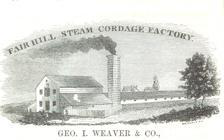

In [ ]:
retrieved_examples['img'][0]

This isn't quite a steam engine but it's also not a completely weird result. We can plot the other results to see what was returned. 

In [ ]:
import matplotlib.pyplot as plt

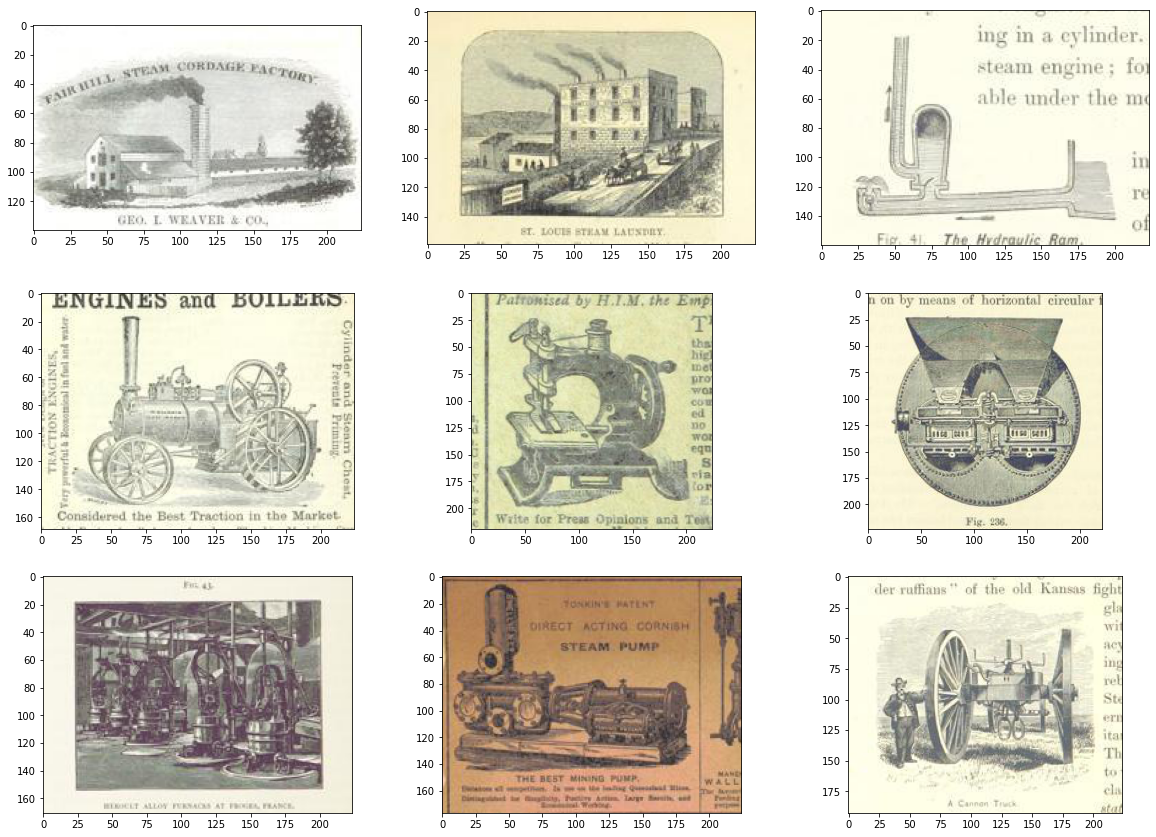

In [ ]:
plt.figure(figsize=(20, 20))
columns = 3
for i in range(9):
    image = retrieved_examples['img'][i]
    plt.subplot(9 / columns + 1, columns, i + 1)
    plt.imshow(image)

Some of these results look fairly close to our input prompt. We can wrap this in a function so can more easily play around with different prompts

In [35]:
def get_image_from_text(text_prompt, number_to_retrieve=9):
    prompt = model.encode(text_prompt)
    scores, retrieved_examples = ds_with_embeddings['train'].get_nearest_examples('embeddings', prompt,k=number_to_retrieve)
    plt.figure(figsize=(20, 20))
    columns = 3
    for i in range(9):
        image = retrieved_examples['img'][i]
        plt.title(text_prompt)
        plt.subplot(9 / columns + 1, columns, i + 1)
        plt.imshow(image)

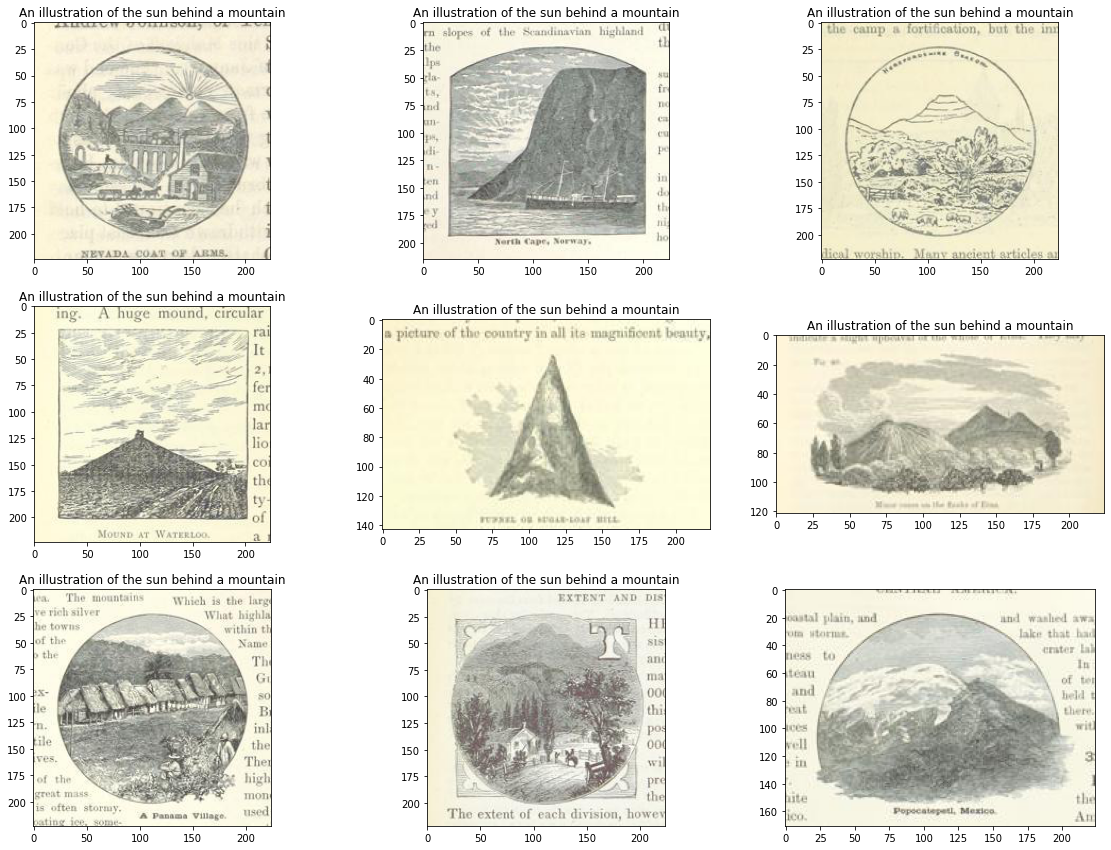

In [36]:
get_image_from_text("An illustration of the sun behind a mountain")

### Trying a bunch of prompts ✨

Now we have a function for getting a few results we can try a bunch of different prompts:

- For some of these I'll choose prompts which are a broad 'category' i.e. 'a musical instrument' or 'an animal', others are specific i.e. 'a guitar'. 

- Out of interest I also tried a boolean operator:  "An illustration of a cat or a dog". 

- Finally I tried something a little more abstract: "an empty abyss"

In [41]:
prompts = ["A musical instrument", "A guitar", "An animal", "An illustration of a cat or a dog", "an empty abyss"]

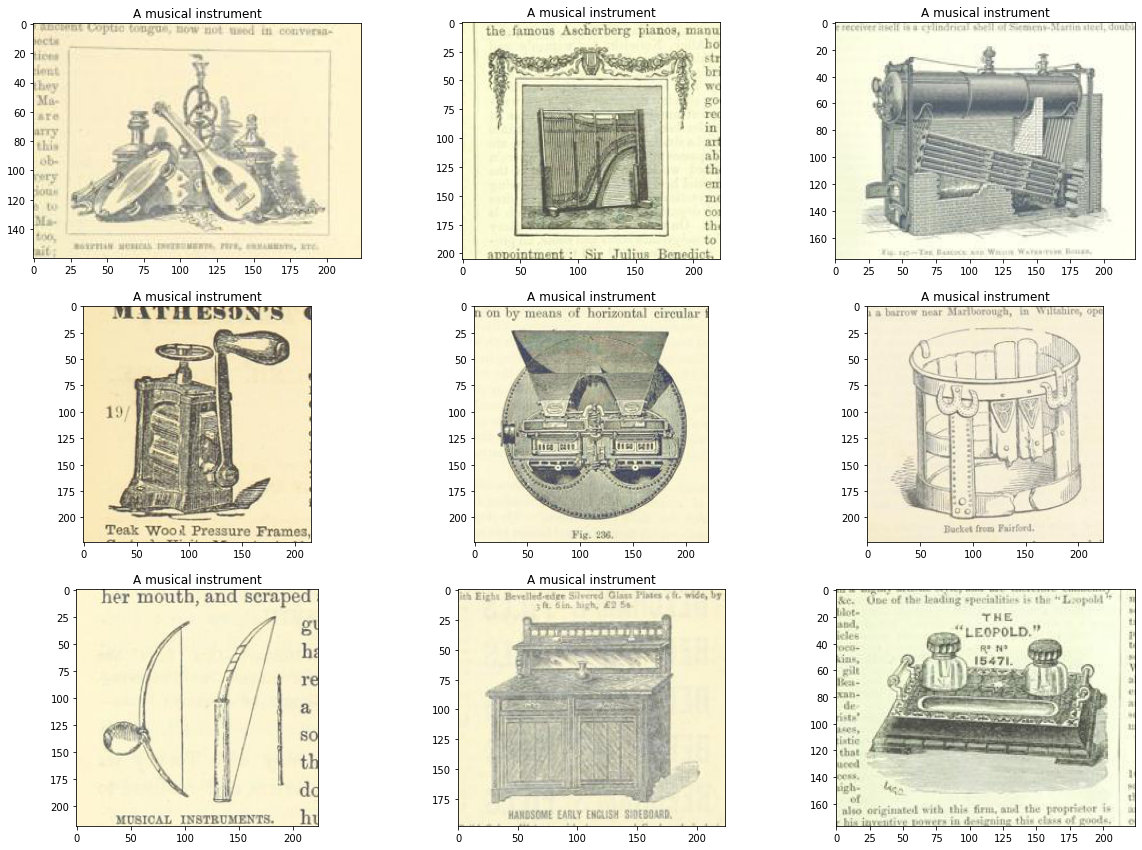

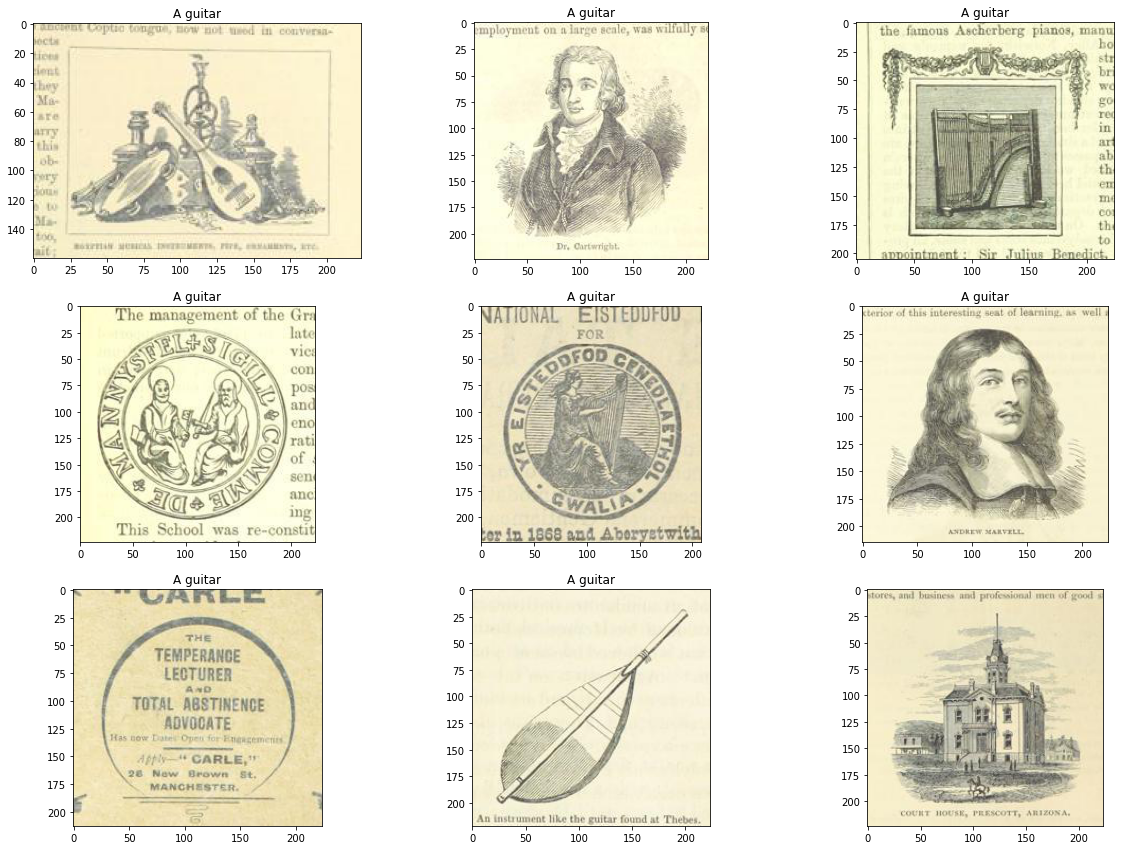

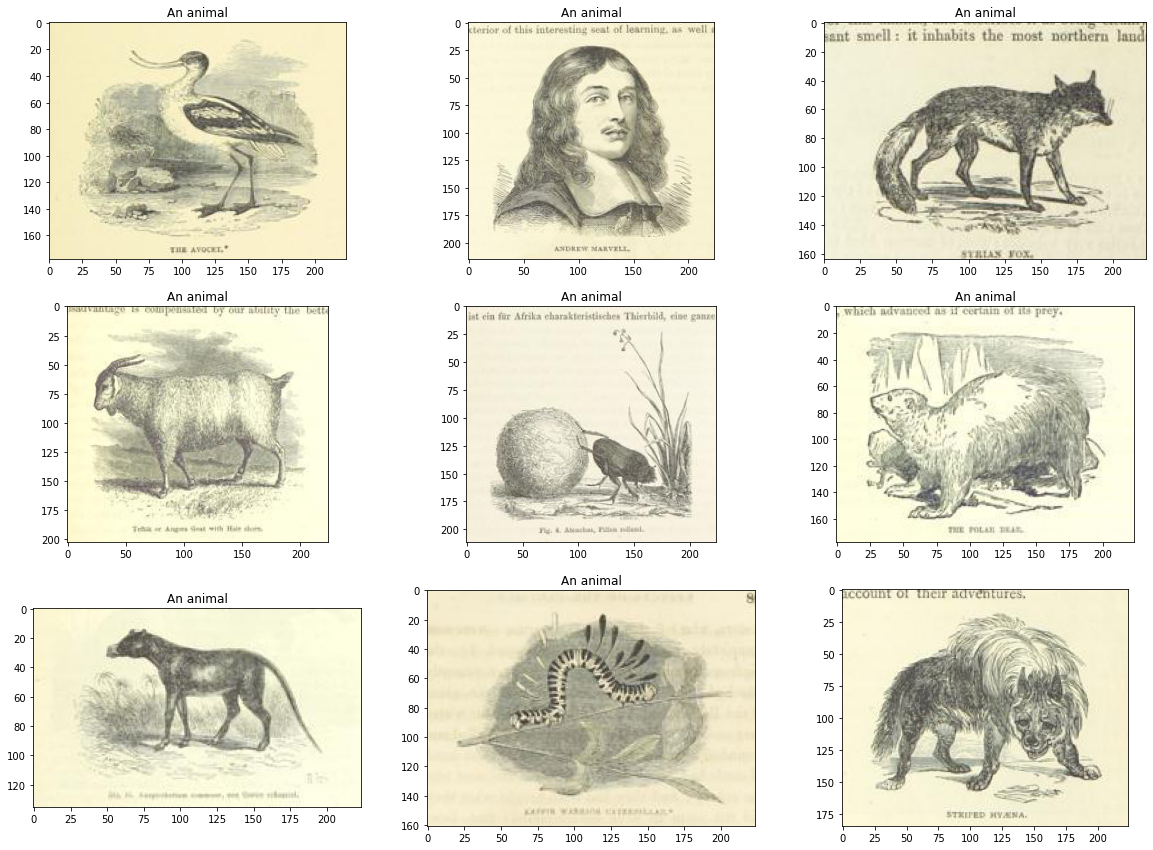

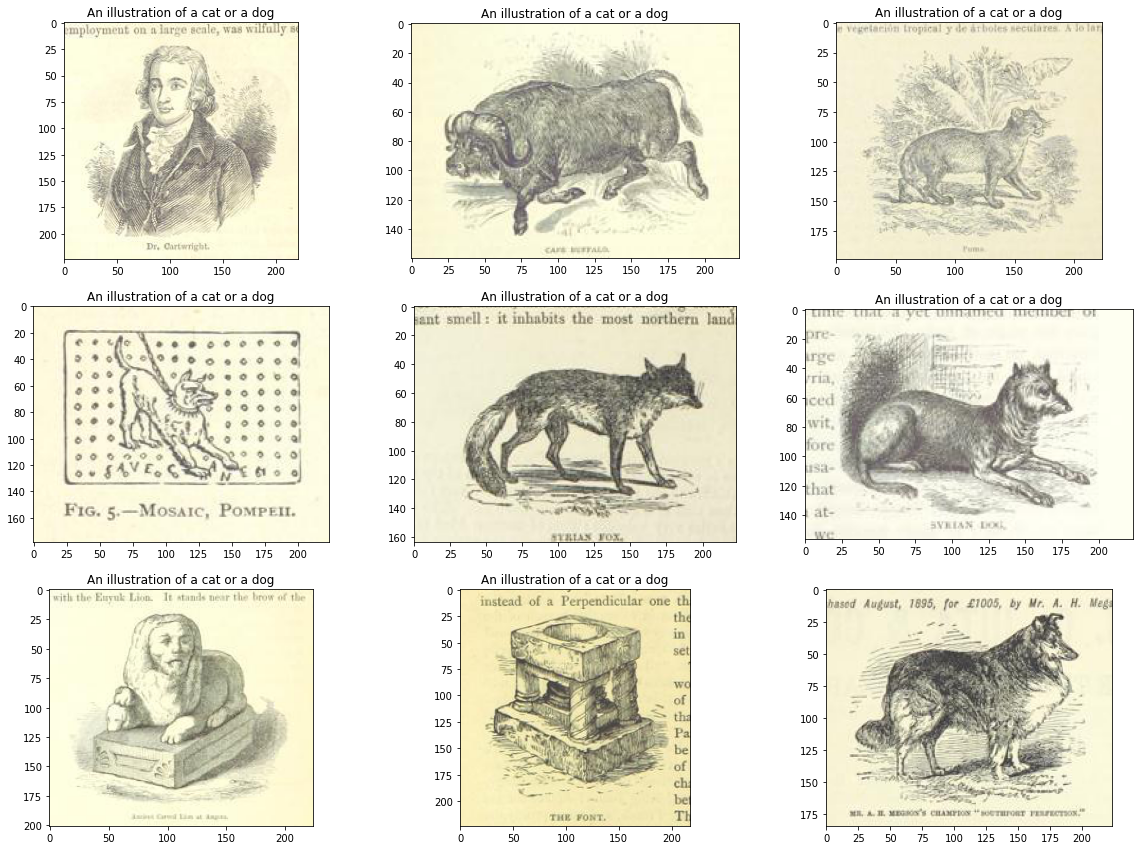

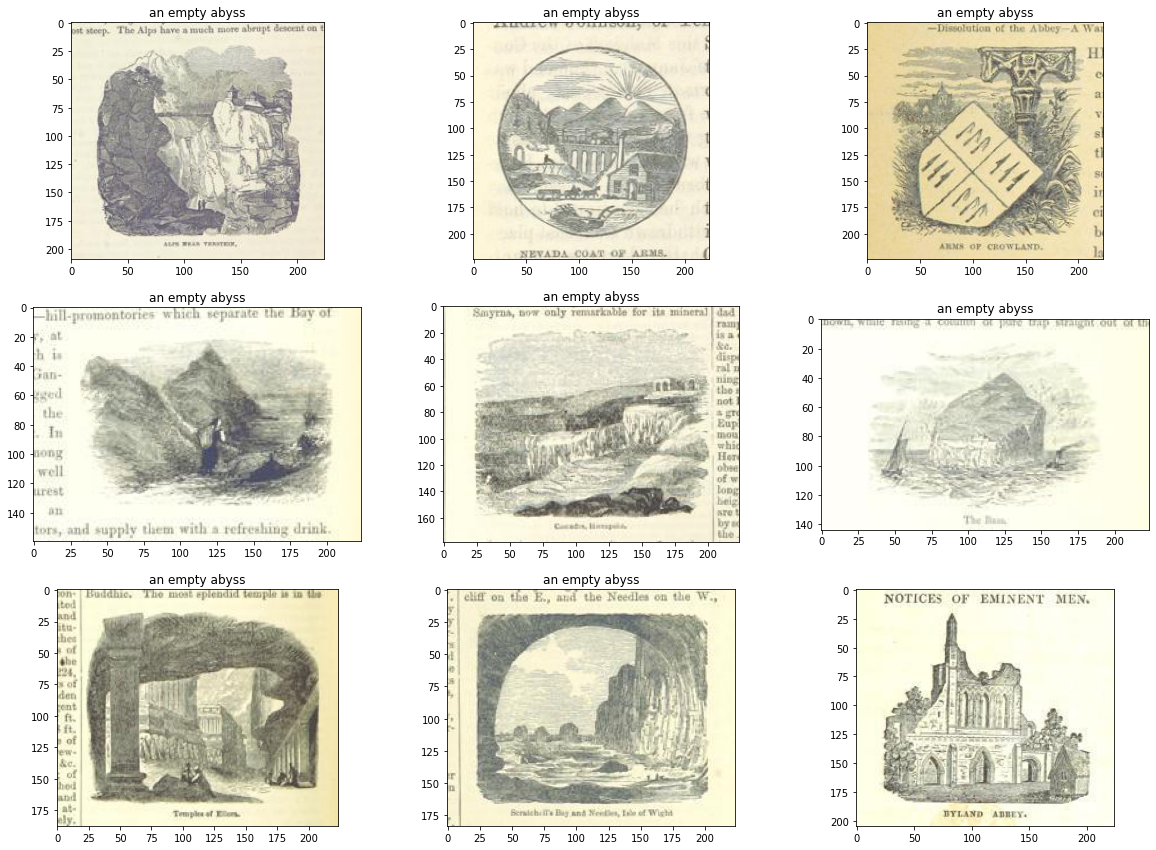

In [42]:
for prompt in prompts:
    get_image_from_text(prompt)

We can see these results aren't always right but they are usually some reasonable results in there. It already seems like this could be useful for searching for a the semantic content of an image in this dataset. However we might hold off on sharing this as is...

## Creating a huggingface space? 🤷🏼

One obvious next step for this kind of project is to create a hugginface [spaces](https://huggingface.co/spaces) demo. This is what I've done for other [models](https://huggingface.co/spaces/BritishLibraryLabs/British-Library-books-genre-classifier-v2)

It was a fairly simple process to get a [Gradio app setup](https://gradio.app/) from the point we got to here. Here is a screenshot of this app.  

![](../images/spaces_image_search.png)


However, I'm a little bit vary about making this public straightaway. Looking at the model card for the CLIP model we can look at the primary intended uses:

> ### Primary intended uses 
We primarily imagine the model will be used by researchers to better understand robustness, generalization, and other capabilities, biases, and constraints of computer vision models. [source](https://huggingface.co/openai/clip-vit-base-patch32)

This is fairly close to what we are interested in here. Particularly we might be interested in how well the model deals with the kinds of images in our dataset (illustrations from mostly 19th century books). The images in our dataset are (probably) fairly different from the training data. The fact that some of the images also contain text might help CLIP since it displays some [OCR ability](https://openai.com/blog/clip/). 

However, looking at the out-of-scope use cases in the model card:

> ### Out-of-Scope Use Cases
Any deployed use case of the model - whether commercial or not - is currently out of scope. Non-deployed use cases such as image search in a constrained environment, are also not recommended unless there is thorough in-domain testing of the model with a specific, fixed class taxonomy. This is because our safety assessment demonstrated a high need for task specific testing especially given the variability of CLIP’s performance with different class taxonomies. This makes untested and unconstrained deployment of the model in any use case currently potentially harmful. [source](https://huggingface.co/openai/clip-vit-base-patch32)

suggests that 'deployment' is not a good idea. Whilst the results I got are interesting I haven't played around with the model enough yet (and haven't done anything more systematic to evaluate its performance and biases). Another additional consideration is the target dataset itself. The images are drawn from books covering a variety of subjects and time periods. There are plenty of books which represent colonial attitudes and as a result some of the images included may represent certain groups of people in a negative way. This could potentially be a bad combo with a tool which allows any arbitrary text input to be encoded as a prompt.

There may be ways around this issue but this will require a bit more thought. 

## Conclusion 

Although I don't have a nice demo to show for it I did get to work out a few more details of how datasets handles images. I've already used it to train some classification models and everything seems to be working smoothly. The ability to push images around on the hub will be super useful for many use cases too. 

I plan to spend a bit more time thinking about whether this a better way of sharing a clip powered image search for the BL book images or not...